In [29]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections
import datetime

from SimioEnv import SimioPickDontMoveEnv
from FunctionApproximators import PolicyEstimator, ValueEstimator
from IPython.core.debugger import set_trace
from gym_helpers import flatten_space_sample

if "../" not in sys.path:
  sys.path.append("../") 
#from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [30]:
# env = gym.make('FrozenLake8x8-v0') # FrozenLake8x8-v0 FrozenLake-v0
# env = SimioFrozenLakeEnv(num_states=64, num_actions=4, log_output=False)
env = SimioPickDontMoveEnv(
    num_locations=8, 
    num_pickers=1, 
    num_agvs=2,
    log_output=False, 
    log_end_episode_only=False
    )

print("Num Pickers: ", env.num_pickers)
print("Num AGVs: ", env.num_agvs)
print("Num Warehouse Locations: ", env.num_locations)

print()
print("Action Space:")
print("=============")
print(env.action_space)
print()
print("Observation Space:")
print("==================")
for statevar in env.observation_space:
    print(statevar)

Num Pickers:  1
Num AGVs:  2
Num Warehouse Locations:  8

Action Space:
MultiDiscrete([13 12 12])

Observation Space:
Discrete(3)
Discrete(11)
Discrete(3)
Discrete(11)
MultiDiscrete([100 100 100 100 100 100 100 100])
Discrete(3)
Discrete(11)
MultiDiscrete([100 100 100 100 100 100 100 100])


In [31]:
# example = {
#     'Status':  0.0 , 
#     'EpisodeNum':  1.0 , 
#     'Reward':  2.0 , 
#     'States':  {
#         'PickerCurrentAction': 3.0, 
#         'PickerLocation': 4.0, 
#         'AGV1CurrentAction': 5.0, 
#         'AGV1Location': 6.0, 
#         'AGV1RemainingOrderQuantities': [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0], 
#         'AGV2CurrentAction': 15.0, 
#         'AGV2Location': 16.0, 
#         'AGV2RemainingOrderQuantities': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0], 
#         'Order1Quantities': [], 
#         'Order2Quantities': [], 
#         'Order3Quantities': [], 
#         'Order4Quantities': [], 
#         'Order5Quantities': []
#     }
# }
# example_state = example['States']
# 
# env.flatten_state(example_state)

In [32]:
# flatten_space_sample(env.observation_space.sample())

# def flatten_space_sample2(sample):
#     return np.array(flatten_space_sample(sample)).reshape(-1, 1).T

In [33]:
# Reshapes a list of integers into a format tensorflow can understand
def reshape_state(state):
    return np.array(state).reshape(-1, 1).T

In [34]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(episode_lengths=np.zeros(num_episodes), episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        state = reshape_state(state)
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            
            # action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            action = [np.random.choice(np.arange(len(prob)), p=prob) for prob in action_probs] # action for each picker, agv
            
            next_state, reward, done, _ = env.step(action)
            next_state = reshape_state(next_state)
            
            # Keep track of the transition
            episode.append(Transition(state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # if td_error > 0.001 or td_error < -0.001:
            #     variables = tf.trainable_variables()
            #     variables_vals = sess.run(variables)
            #     varlist = []
            #     for var, val in zip(variables, variables_vals):
            #         print("var: {}, value: {}".format(var.name, val))
            
            
            # Update the value estimator
            value_loss = estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            policy_loss = estimator_policy.update(state, td_error, action)
            
            print("\r[step {}][ep {}/{}] Vn={} TD={} TDE={} r={} Vloss={} Ploss={}".format(
                 t,
                 i_episode+1,
                 num_episodes,
                 
                 value_next,
                 td_target,
                 td_error,
                 reward,
                 value_loss,
                 policy_loss), end="")
            
            # if td_error > 0.001 or td_error < -0.001:
            #     variables = tf.trainable_variables()
            #     variables_vals = sess.run(variables)
            #     varlist = []
            #     for var, val in zip(variables, variables_vals):
            #         print("var: {}, value: {}".format(var.name, val))
            
            # Print out which step we're on, useful for debugging.
            # print("\rStep {} @ Episode {}/{} ({})\t\t\t\t\t".format(t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # if td_target > 0.0001 or td_target < -0.0001:
            #     print("============================")
            #     print("Step {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]))
            #     print("td target", td_target, "td error", td_error)
            #     print("value loss", value_loss, "policy loss", policy_loss)
            #     print("============================")
            # print("\rStep {} @ Episode {}/{} ({})\t\t\t\t\t".format(t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            if done:
                break
                
            state = next_state
        env.finalize()
        
    return stats

In [35]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(env, learning_rate=0.0001, hidden_size=30)
value_estimator = ValueEstimator(env, learning_rate=0.0001)

In [8]:
%load_ext tensorboard.notebook
#%reload_ext tensorboard.notebook
logs_path = "./tensorboard_actorcriticsimio2"
summary_writer = tf.summary.FileWriter(logdir=logs_path, graph=tf.get_default_graph()) # , graph=g
%tensorboard --logdir tensorboard_actorcriticsimio2/

Reusing TensorBoard on port 6006 (pid 26856), started 3:31:20 ago. (Use '!kill 26856' to kill it.)

In [ ]:
#policytable = []
#valuetable = []

print("started run:", datetime.datetime.now())

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    stats = actor_critic(env, policy_estimator, value_estimator, num_episodes=100, discount_factor=1.0)

    # Output the final policy and value tables
    #for i in range(env.observation_space.n):
    #    policytable.append(policy_estimator.predict(i))
    #    valuetable.append(value_estimator.predict(i))
    variables = tf.trainable_variables()
    variables_vals = sess.run(variables)
    # print(variables) #some infos about variables...
    varlist = []
    for var, val in zip(variables, variables_vals):
        varlist.append({var.name: val})
        # print("var: {}, value: {}".format(var.name, val)) #...or sort it in a list....
    # print varlist
print("ended run:", datetime.datetime.now())

started run: 2019-10-09 20:24:38.638766
[step 4501][ep 19/100] Vn=0.004643026739358902 TD=0.004596596471965313 TDE=-4.6430267393589124e-05 r=0.0 Vloss=2.155759348809738e-09 Ploss=[-1.379816e-05, -7.961908e-05, -2.9610621e-05]

In [10]:
varlist

[{'policy_estimator/fully_connected/weights:0': array([[-1.14004396e-01,  1.83086380e-01,  1.17731597e-02,
          -1.29751280e-01, -1.74210414e-01,  1.72400683e-01,
           2.38109693e-01, -1.79006532e-02, -2.05481216e-01,
           1.19665779e-01, -4.86306734e-02, -3.17904025e-01,
          -3.69912423e-02,  2.89769560e-01, -1.79378331e-01,
          -2.67038703e-01, -2.63720274e-01,  1.46454766e-01,
          -1.96521074e-01,  1.04784682e-01,  2.99727060e-02,
           1.13930553e-01,  6.11939579e-02, -1.16202489e-01,
          -8.94072056e-02, -1.88625664e-01, -1.81457683e-01,
          -1.35266319e-01,  1.66826189e-01, -2.26917207e-01],
         [-2.06630945e-01, -1.28036097e-01, -3.39947976e-02,
           5.49576044e-01,  2.43740007e-01, -2.75552750e-01,
           2.95668170e-02, -1.05778180e-01, -2.54256040e-01,
          -1.48126855e-01,  4.44928333e-02, -4.50093560e-02,
          -3.25076282e-02,  2.67004848e-01, -3.54119480e-01,
          -3.96830231e-01,  3.56873453

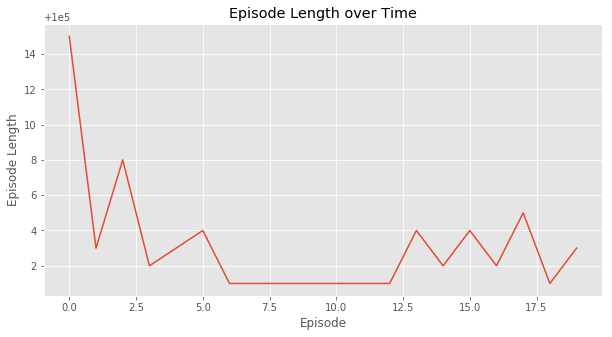

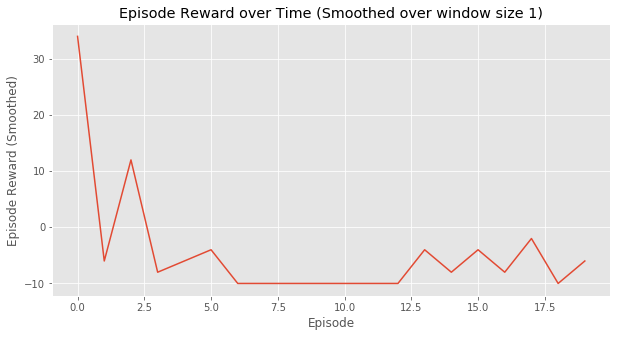

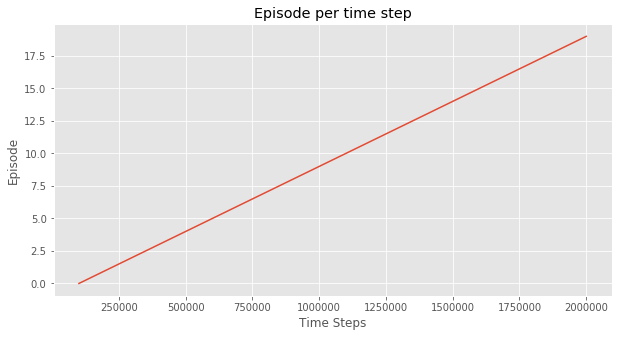

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plotting.plot_episode_stats(stats, smoothing_window=1)